Using device: mps
Training data length   = 1000 hours
Validation data length = 1000 hours


/var/folders/r8/txtlfyt94hj558w8mlkw1pkr0000gn/T/ipykernel_29122/1997174612.py:400: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_t = torch.FloatTensor(states_b).to(device)


Episode 1/8 | Reward=0.0136 | TrainLoss=0.000155 | ValLoss=0.000014 | ε=0.900
Episode 2/8 | Reward=0.0076 | TrainLoss=0.000008 | ValLoss=0.000006 | ε=0.712
Episode 3/8 | Reward=0.0208 | TrainLoss=0.000003 | ValLoss=0.000002 | ε=0.566
Episode 4/8 | Reward=0.0096 | TrainLoss=0.000001 | ValLoss=0.000001 | ε=0.452
Episode 5/8 | Reward=-0.0034 | TrainLoss=0.000000 | ValLoss=0.000000 | ε=0.363
Episode 6/8 | Reward=-0.0017 | TrainLoss=0.000000 | ValLoss=0.000000 | ε=0.294
Episode 7/8 | Reward=0.0035 | TrainLoss=0.000000 | ValLoss=0.000000 | ε=0.240
Episode 8/8 | Reward=0.0122 | TrainLoss=0.000000 | ValLoss=0.000000 | ε=0.198


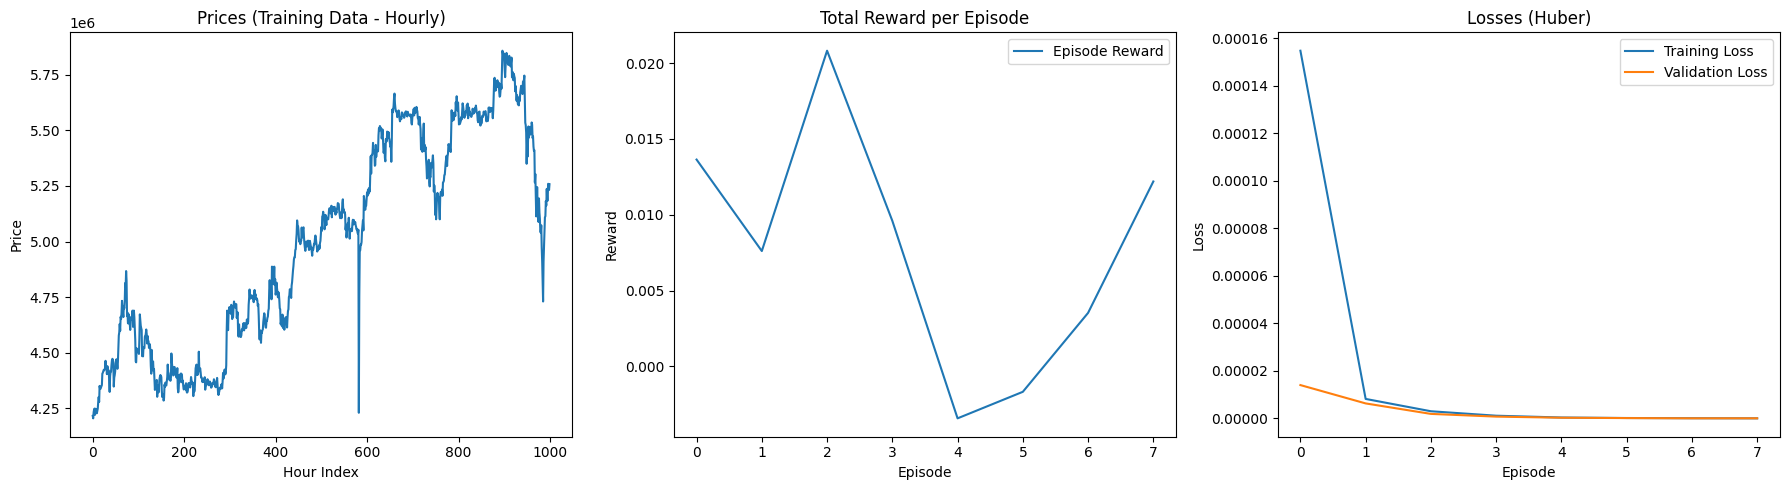


----- Validation Results (Hourly) -----
 Starting Balance: 5,000,000.00 KRW
 Final Balance:    4,823,450.23 KRW
 Total PnL:        -176,549.77 KRW (-3.53%)


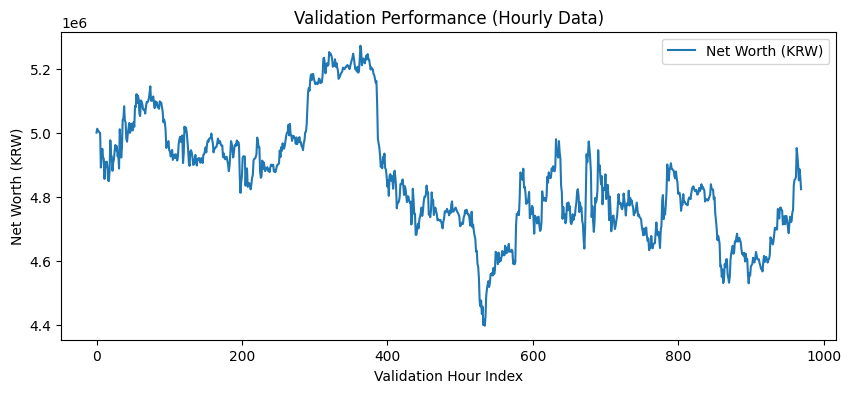

In [1]:
# o3 model

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Device selection
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)
print(f"Using device: {device}")

def fetch_historical_data(quote="KRW", target="ETH", hours=5000):
    base_url = f"https://api.bithumb.com/public/candlestick/{target}_{quote}/1h"
    
    try:
        response = requests.get(base_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        if data.get("status") != "0000":
            print(f"API Error: {data.get('message', 'Unknown error')}")
            return None
            
        candlesticks = data.get("data", [])
        if not candlesticks:
            print("No hourly data found in response.")
            return None
            
        prices = [float(entry[2]) for entry in candlesticks[-hours:]]
        return np.array(prices, dtype=np.float32)
        
    except Exception as e:
        print(f"Error fetching hourly data: {str(e)}")
        return None

class EnhancedTradingEnv:
    def __init__(self, prices, window_size=30, initial_balance=1000000.0, longterm_weight=0.1):
        """
        Parameters:
          prices: np.array of price values.
          window_size: number of past prices (and other features) to include in the observation.
          initial_balance: starting capital.
          longterm_weight: weight factor to boost final reward based on overall PnL.
        """
        self.prices = prices
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.longterm_weight = longterm_weight
        self.reset()
        
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0.0
        # Pre-fill net_worth history with the starting balance for normalization in observations
        self.net_worth = [self.initial_balance] * self.window_size
        return self._get_observation()
    
    def _get_observation(self):
        price_window = self.prices[self.current_step - self.window_size : self.current_step]
        
        mean_p = np.mean(price_window)
        std_p = np.std(price_window) if np.std(price_window) > 0 else 1.0
        normalized_prices = (price_window - mean_p) / std_p
        
        returns = np.diff(price_window) / price_window[:-1] if len(price_window) > 1 else [0]
        volatility = np.std(returns) if len(returns) > 1 else 0.0
        
        # The observation now consists of the normalized price window plus extra features:
        # normalized balance, current position (in asset units), and volatility.
        return np.concatenate([
            normalized_prices,
            [
                self.balance / self.initial_balance,
                self.position,
                volatility
            ]
        ]).astype(np.float32)
    
    def step(self, action):
        """
        New Action Mapping:
          0: Hold (do nothing)
          1: Buy with 10% of available funds
          2: Buy with 25% of available funds
          3: Buy with 50% of available funds
          4: Sell 10% of current position
          5: Sell 25% of current position
          6: Sell 50% of current position
        """
        current_price = self.prices[self.current_step]
        prev_net_worth = self.balance + self.position * current_price
        
        # Map the discrete action to an operation and proportion:
        action_map = {
            0: ('hold', 0.0),
            1: ('buy', 0.1),
            2: ('buy', 0.25),
            3: ('buy', 0.5),
            4: ('sell', 0.1),
            5: ('sell', 0.25),
            6: ('sell', 0.5)
        }
        action_type, proportion = action_map.get(action, ('hold', 0.0))
        
        if action_type == 'buy':
            if self.balance > 0:
                # Invest a fraction of the maximum possible buy (i.e. all available funds)
                max_buy = self.balance / current_price
                amount_to_buy = proportion * max_buy
                self.position += amount_to_buy
                self.balance -= amount_to_buy * current_price
        elif action_type == 'sell':
            if self.position > 0:
                amount_to_sell = proportion * self.position
                self.balance += amount_to_sell * current_price
                self.position -= amount_to_sell
        # 'hold' does nothing
        
        # Update net worth
        current_net_worth = self.balance + self.position * current_price
        self.net_worth.append(current_net_worth)
        
        # Compute reward as the log change in net worth (if previous worth is positive)
        reward = np.log(current_net_worth / prev_net_worth) if prev_net_worth > 0 else 0.0
        
        # Check for termination condition
        done = (self.current_step >= len(self.prices) - 1)
        # If done, add a bonus reward that scales with the overall profit (longterm PnL)
        if done:
            longterm_bonus = self.longterm_weight * ((current_net_worth - self.initial_balance) / self.initial_balance)
            reward += longterm_bonus
        
        self.current_step += 1
        return self._get_observation(), reward, done

class CNN_DQN(nn.Module):
    def __init__(self, window_size, num_actions):
        super(CNN_DQN, self).__init__()
        self.window_size = window_size

        # 1D CNN feature extractor for the price window
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        conv_out_size = self._conv_out(window_size)

        # Fully-connected layers (combining CNN features and extra features)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size + 3, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_actions)
        )

    def _conv_out(self, size):
        with torch.no_grad():
            o = self.conv(torch.zeros(1, 1, size))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        batch_size = x.size(0)
        prices = x[:, :self.window_size]
        extra = x[:, self.window_size:]
        
        conv_input = prices.unsqueeze(1)
        conv_output = self.conv(conv_input)
        conv_flat = conv_output.view(batch_size, -1)
        
        combined = torch.cat([conv_flat, extra], dim=1)
        q_values = self.fc(combined)
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

def compute_validation_loss(model, target_net, prices, window_size, initial_balance, gamma=0.99, batch_size=64):
    """
    Runs a validation episode (using a greedy policy) and computes the average Huber loss versus the target network.
    """
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    done = False
    transitions = []
    
    while not done:
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()
        next_state, reward, done = env.step(action)
        transitions.append((state, action, reward, next_state, done))
        state = next_state
    
    total_loss = 0.0
    count = 0
    huber = nn.SmoothL1Loss()

    with torch.no_grad():
        for i in range(0, len(transitions), batch_size):
            batch = transitions[i:i+batch_size]
            states, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)
            
            states_t = torch.FloatTensor(states).to(device)
            actions_t = torch.LongTensor(actions_b).to(device)
            rewards_t = torch.FloatTensor(rewards_b).to(device)
            next_states_t = torch.FloatTensor(next_states_b).to(device)
            dones_t = torch.BoolTensor(dones_b).to(device)
            
            current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
            
            # Double DQN style target:
            online_actions = model(next_states_t).argmax(dim=1, keepdim=True)
            next_q = target_net(next_states_t).gather(1, online_actions).squeeze(1)
            
            target_q = rewards_t + gamma * next_q * (~dones_t)
            loss = huber(current_q, target_q)
            
            total_loss += loss.item() * len(batch)
            count += len(batch)

    avg_val_loss = total_loss / count if count > 0 else 0.0
    return avg_val_loss

def validate_model(model, prices, window_size=30, initial_balance=10000.0):
    env = EnhancedTradingEnv(prices=prices, window_size=window_size, initial_balance=initial_balance)
    state = env.reset()
    
    done = False
    prev_net_worth = env.net_worth[-1]
    hourly_records = []
    
    while not done:
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()
        
        next_state, _, done = env.step(action)
        current_net_worth = env.net_worth[-1]
        
        hourly_pnl = current_net_worth - prev_net_worth
        hourly_records.append({
            "hour_index": env.current_step,
            "action": action,
            "net_worth": current_net_worth,
            "hourly_pnl": hourly_pnl
        })
        
        prev_net_worth = current_net_worth
        state = next_state
    
    final_balance = env.net_worth[-1]
    total_pnl = final_balance - initial_balance
    pct_return = (total_pnl / initial_balance) * 100.0
    
    print("\n----- Validation Results (Hourly) -----")
    print(f" Starting Balance: {initial_balance:,.2f} KRW")
    print(f" Final Balance:    {final_balance:,.2f} KRW")
    print(f" Total PnL:        {total_pnl:,.2f} KRW ({pct_return:.2f}%)")
    
    return hourly_records

def plot_training_progress(episode_rewards, prices, training_losses, validation_losses):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(prices)
    axs[0].set_title("Prices (Training Data - Hourly)")
    axs[0].set_xlabel("Hour Index")
    axs[0].set_ylabel("Price")
    
    axs[1].plot(episode_rewards, label="Episode Reward")
    axs[1].set_title("Total Reward per Episode")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Reward")
    axs[1].legend()
    
    axs[2].plot(training_losses, label="Training Loss")
    axs[2].plot(validation_losses, label="Validation Loss")
    axs[2].set_title("Losses (Huber)")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1) Fetch data
    coin = "ETH"
    quote = "KRW"
    total_hours = 2000
    all_prices = fetch_historical_data(quote=quote, target=coin, hours=total_hours)
    
    if all_prices is None or len(all_prices) < total_hours:
        print("Failed to fetch enough hourly data.")
        exit(1)
        
    # 2) Split data into training and validation sets
    split_index = len(all_prices) // 2
    training_prices   = all_prices[:split_index]
    validation_prices = all_prices[split_index:]
    
    print(f"Training data length   = {len(training_prices)} hours")
    print(f"Validation data length = {len(validation_prices)} hours")
    
    # 3) Initialize the environment.
    # Note: Adjust initial_balance and longterm_weight as desired.
    env = EnhancedTradingEnv(prices=training_prices, window_size=30, initial_balance=10000, longterm_weight=0.1)
    state_size = len(env._get_observation())
    # Update: now we have 7 discrete actions
    num_actions = 7
    
    # 4) Initialize the model and target network.
    model = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net = CNN_DQN(window_size=30, num_actions=num_actions).to(device)
    target_net.load_state_dict(model.state_dict())
    target_net.eval()
    
    # 5) Training hyperparameters (with a smaller weight decay)
    optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-3)
    replay_buffer = ReplayBuffer(capacity=20000)
    
    batch_size = 64
    gamma = 0.99
    
    # Epsilon-greedy parameters
    epsilon_start = 0.9
    epsilon_end = 0.05
    epsilon_decay = 4  # tweak as necessary
    
    # Soft update (Polyak averaging) parameter
    tau = 0.01  # tweak as necessary
    
    episodes = 8  # Consider increasing the number of episodes for more robust learning
    max_steps_per_episode = 2000  # safeguard in case data is large

    # Logging lists
    episode_rewards = []
    training_losses = []
    validation_losses = []
    
    huber_loss_fn = nn.SmoothL1Loss()
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0.0
        episode_loss = 0.0
        training_steps = 0
        
        # Epsilon decay schedule
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * episode / epsilon_decay)
        
        for step_i in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_t).argmax(dim=1).item()
            else:
                action = random.randint(0, num_actions - 1)
            
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            
            # Train if enough samples are available
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states_b, actions_b, rewards_b, next_states_b, dones_b = zip(*batch)
                
                states_t = torch.FloatTensor(states_b).to(device)
                actions_t = torch.LongTensor(actions_b).to(device)
                rewards_t = torch.FloatTensor(rewards_b).to(device)
                next_states_t = torch.FloatTensor(next_states_b).to(device)
                dones_t = torch.BoolTensor(dones_b).to(device)
                
                # Compute current Q-values for the chosen actions
                current_q = model(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
                
                # Double DQN target computation:
                with torch.no_grad():
                    online_actions = model(next_states_t).argmax(dim=1, keepdim=True)
                    next_q = target_net(next_states_t).gather(1, online_actions).squeeze(1)
                    target_q = rewards_t + gamma * next_q * (~dones_t)
                
                loss = huber_loss_fn(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
                optimizer.step()
                
                episode_loss += loss.item()
                training_steps += 1
            
            # Soft update of target network parameters
            with torch.no_grad():
                for param, target_param in zip(model.parameters(), target_net.parameters()):
                    target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
            
            if done:
                break
        
        episode_rewards.append(total_reward)
        avg_train_loss = episode_loss / (training_steps if training_steps > 0 else 1.0)
        training_losses.append(avg_train_loss)
        
        # Compute validation loss on the separate validation dataset
        val_loss = compute_validation_loss(
            model=model, 
            target_net=target_net, 
            prices=validation_prices, 
            window_size=30, 
            initial_balance=10000.0,
            gamma=gamma,
            batch_size=batch_size
        )
        validation_losses.append(val_loss)
        
        print(f"Episode {episode+1}/{episodes} | "
              f"Reward={total_reward:.4f} | "
              f"TrainLoss={avg_train_loss:.6f} | "
              f"ValLoss={val_loss:.6f} | "
              f"ε={epsilon:.3f}")

    # Plot the training progress
    plot_training_progress(episode_rewards, training_prices, training_losses, validation_losses)
    
    # Final validation run with a larger starting balance
    validation_start_balance = 5_000_000.0
    validation_data = validate_model(
        model,
        prices=validation_prices, 
        window_size=30, 
        initial_balance=validation_start_balance
    )
    
    # Plot net worth over the validation episode
    networth_vals = [r["net_worth"] for r in validation_data]
    plt.figure(figsize=(10, 4))
    plt.plot(networth_vals, label="Net Worth (KRW)")
    plt.title("Validation Performance (Hourly Data)")
    plt.xlabel("Validation Hour Index")
    plt.ylabel("Net Worth (KRW)")
    plt.legend()
    plt.show()
